# Integral analysis

In [1]:
import sys
sys.path.append('../')
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

plt.rcParams["figure.figsize"] = [16,9]
sns.set(font_scale=3.0)

from network import run_network_recall, train_network, run_network_recall_limit
from connectivity import designed_matrix_sequences, designed_matrix_sequences_local
from analysis import get_recall_duration_for_pattern, get_recall_duration_sequence, create_sequence_chain
from analysis import time_t1, time_t2, time_t1_local, time_t2_local, time_t2_complicated
from network import run_network_recall_limit_end

## The analysis

In [2]:
def z_filter(t_vector, tau_z, T1, T_start):
    y = np.zeros_like(t_vector)
    for index_t, t in enumerate(t_vector):
        max_value = 1 - np.exp(-(T1) / tau_z)
        if t < T_start:
            y[index_t] = 0.0
        if t >= T_start and t < (T1 + T_start):
            y[index_t] = 1 - np.exp(-(t - T_start) / tau_z)

        if t >= (T1 + T_start):
            y[index_t] = max_value * np.exp(-(t - T_start - T1) / tau_z)
    
    return y

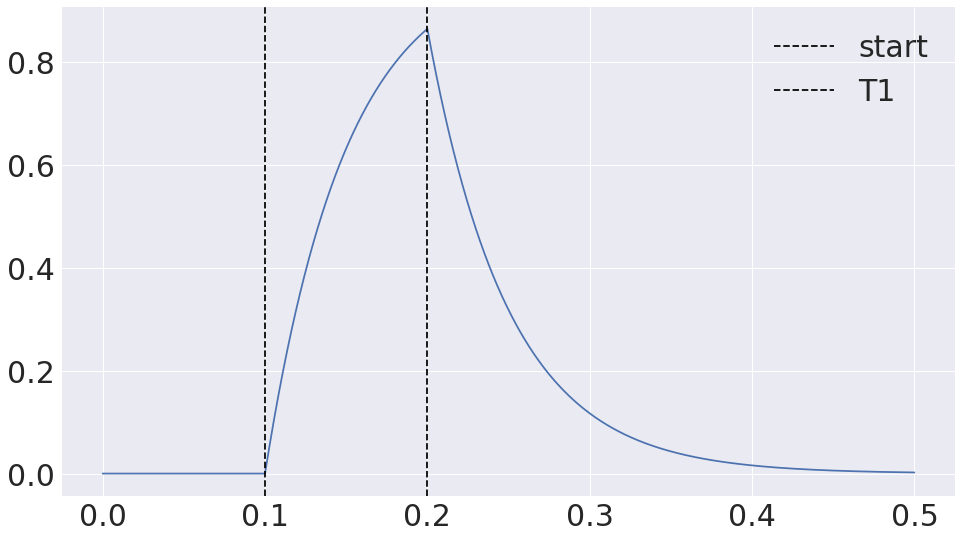

In [4]:
tau_z = 0.050
T1 = 0.100 
T_start = 0.100
tau_z_post = 0.005

dt = 0.0001
t = np.arange(0.0, 0.500, dt)
z = z_filter(t, tau_z, T1, T_start)


plt.plot(t, z)
plt.axvline(T_start, label='start', ls='--', color='black')
plt.axvline(T1 + T_start, label='T1', ls='--', color='black')

plt.legend();

In [5]:
def grow(t, tau_z):
    aux = (1 - np.exp( -t / tau_z))
    return aux

def decay(t, tau_z, T1):
    max_value = 1 - np.exp(-T1 / tau_z)
    
    return max_value * np.exp(-(t - T1) / tau_z)

def z_filter_simple(t, tau_z, T1):
    if t <= T1:
        x = grow(t, tau_z)
        return x
    if t > T1:
        return decay(t, tau_z, T1)
    
def box_car_simple(t, T1, T2):
    if t <= T2 and t >= T1:
        return 1.0
    else:
        return 0
    

box_car = np.vectorize(box_car_simple)    
z_filter_vectorized = np.vectorize(z_filter_simple)

In [9]:
tau_z = 0.050
T_start = 0.0
T1 = 0.100 
T2 = 0.200

tau_z_post = 0.050

dt = 0.001
t = np.arange(0, 0.500, dt)
z = z_filter(t, tau_z, T1, T_start)
z_post = box_car(t, T1, T2)
z_product=  z * z_post
z_negative = z * (1 - z_post)

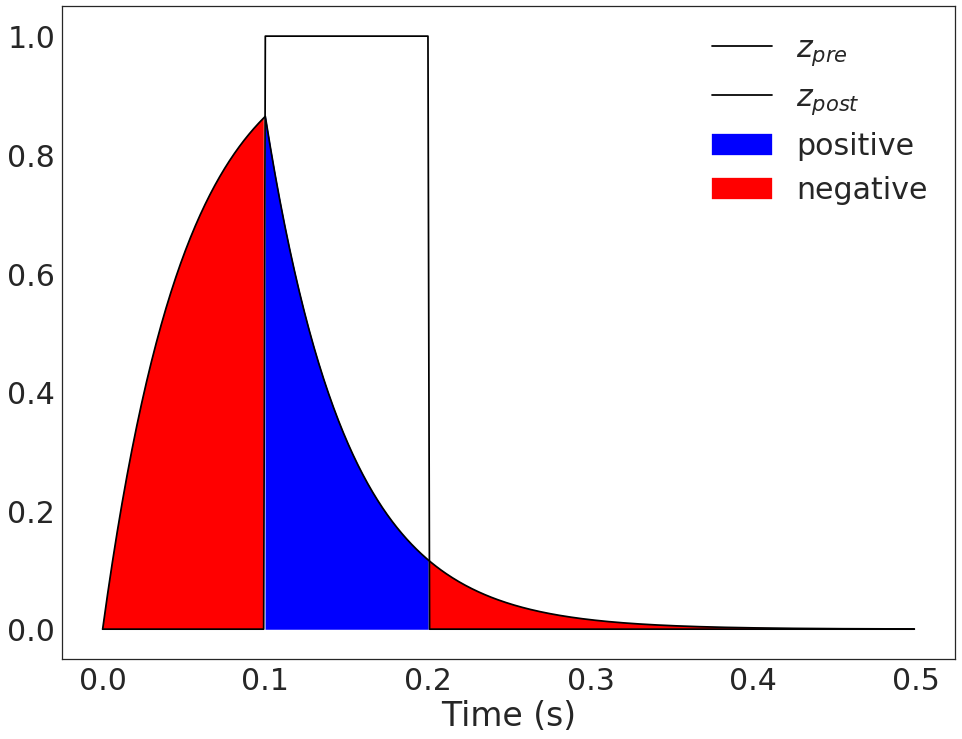

In [10]:
tau_z = 0.050
T_start = 0.0
T1 = 0.100 
T2 = 0.200

tau_z_post = 0.050

dt = 0.001
t = np.arange(0, 0.500, dt)
z = z_filter(t, tau_z, T1, T_start)
z_post = box_car(t, T1, T2)
z_product=  z * z_post
z_negative = z * (1 - z_post)

sns.set_style('white')

fig = plt.figure(figsize=(16, 12))
ax =  fig.add_subplot(111)


ax.plot(t, z, color='black', label=r'$z_{pre}$')
ax.plot(t, z_post, color='black', label=r'$z_{post}$')
ax.set_xlabel('Time (s)')

x_fill = (t <= T2) * (t >= T1) 
ax.fill_between(t, 0, z, where=x_fill, color='blue', label='positive')
ax.fill_between(t, 0 , z, where=np.logical_not(x_fill), color='red', label='negative')

ax.legend()

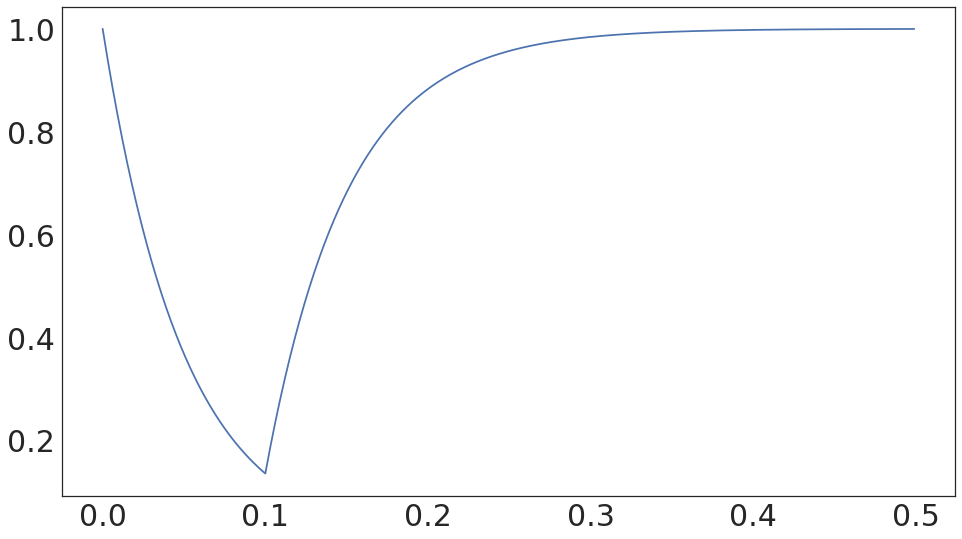

In [11]:
plt.plot(t, 1 - z)

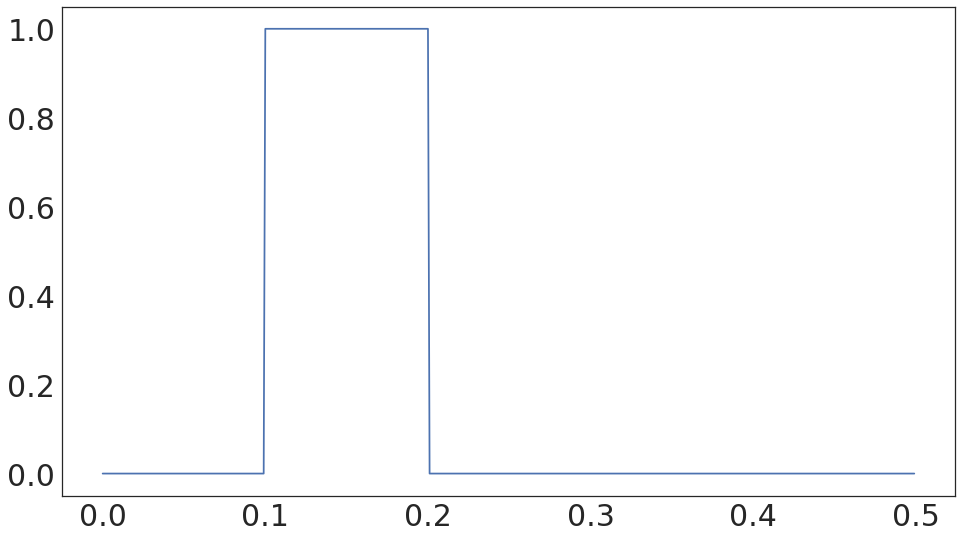

In [18]:
z_negative = z_post * (1 - z) + z * z_post
plt.plot(t, z_negative);

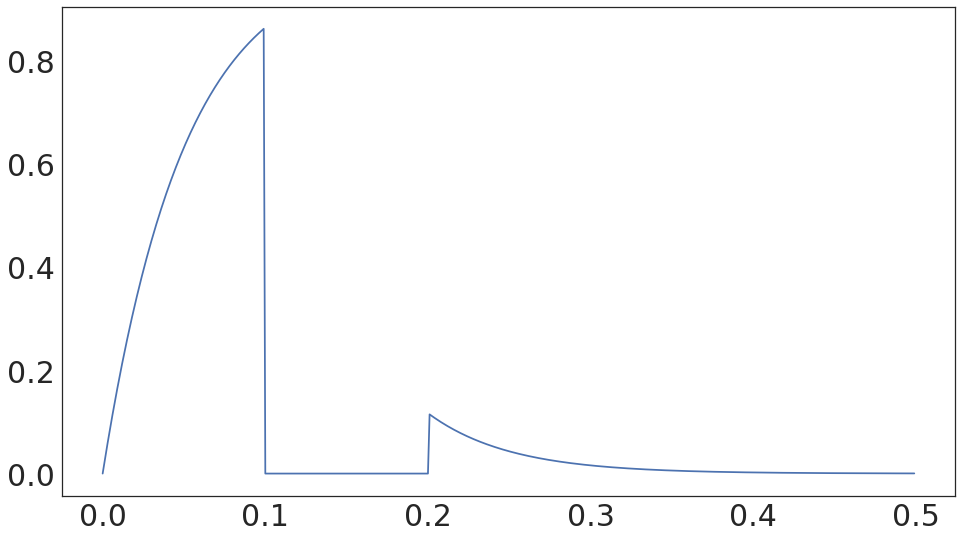

In [13]:
z_negative = z * (1 - z_post)
plt.plot(t, z_negative)

#### Effects on learning of the pre-synaptic rule

In [23]:
w_max = 10
w_min = -10

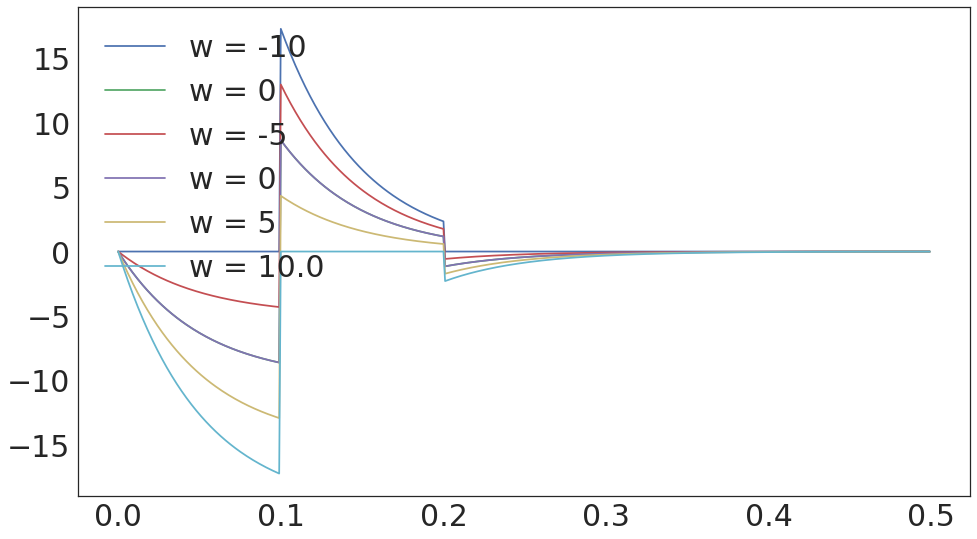

In [24]:
w_collection = [-10,0, -5, 0, 5, 10.0]

for w in w_collection:
    dw = (w_max - w) * z_post * z + (w_min - w) * (1 - z_post) * z
    plt.plot(t, dw, label='w = ' + str(w))


plt.legend();


Let's separate the contributions

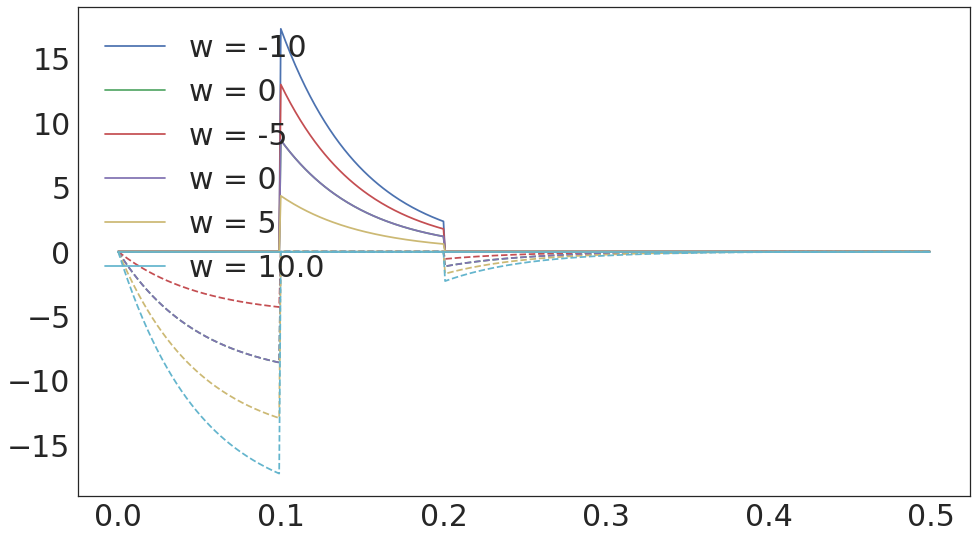

In [32]:
w_collection = [-10,0, -5, 0, 5, 10.0]

for w in w_collection:
    dw_hebbian = (w_max - w) * z_post * z 
    dw_gatting = (w_min - w) * (1 - z_post) * z
    ln, = plt.plot(t, dw_hebbian, label='w = ' + str(w))
    plt.plot(t, dw_gatting, '--', color=ln.get_color())
    


plt.legend();


In [31]:
ln.get_color()

(0.8, 0.7254901960784313, 0.4549019607843137)

#### Now if we use the post-synaptic gating

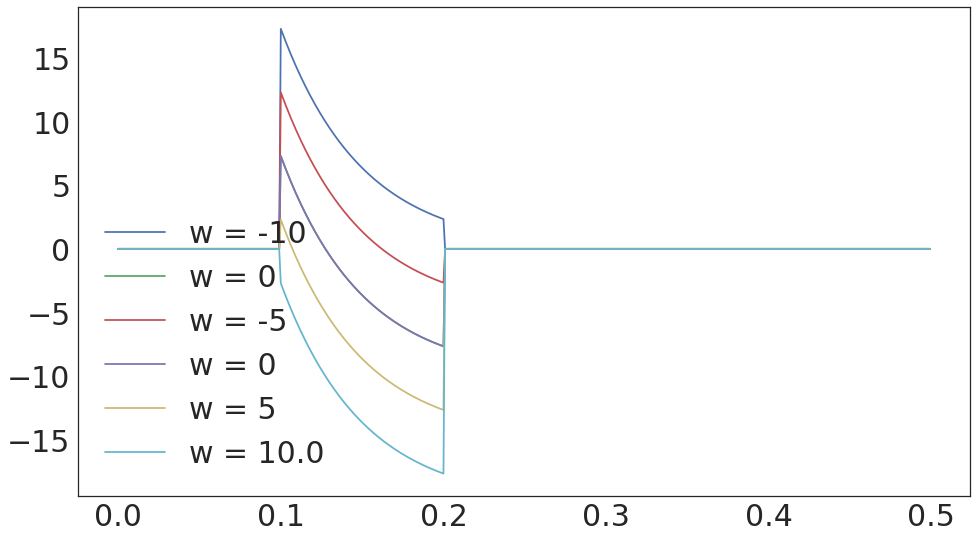

In [28]:
w_collection = [-10,0, -5, 0, 5, 10.0]

for w in w_collection:
    dw = (w_max - w) * z_post * z + (w_min - w) * (1 - z) * z_post
    plt.plot(t, dw, label='w = ' + str(w))
    
plt.legend();

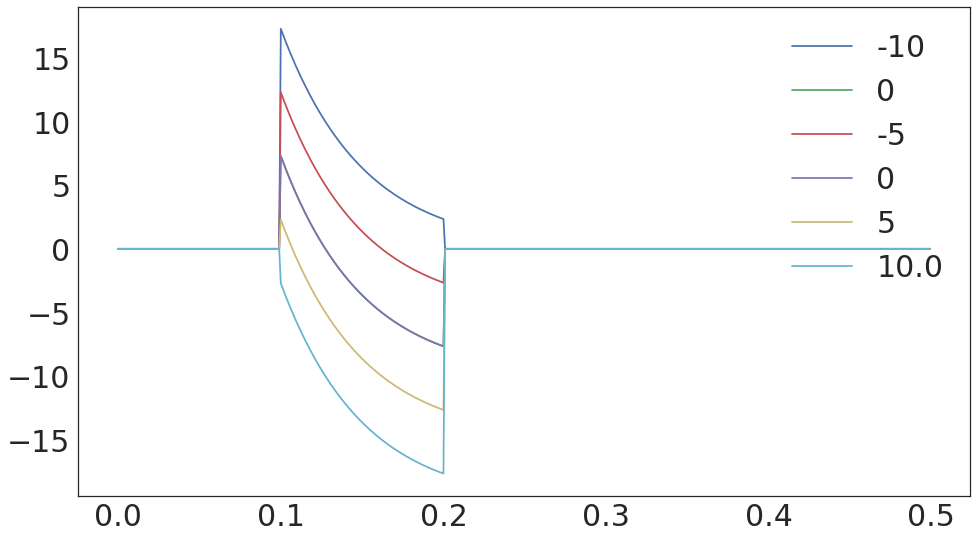

In [29]:
w_collection = [-10,0, -5, 0, 5, 10.0]

for w in w_collection:
    dw = (w_max - w_min) * z * z_post + (w_min - w) * z_post
    plt.plot(t, dw, label=str(w))
    
plt.legend()

Let's separate the contributions

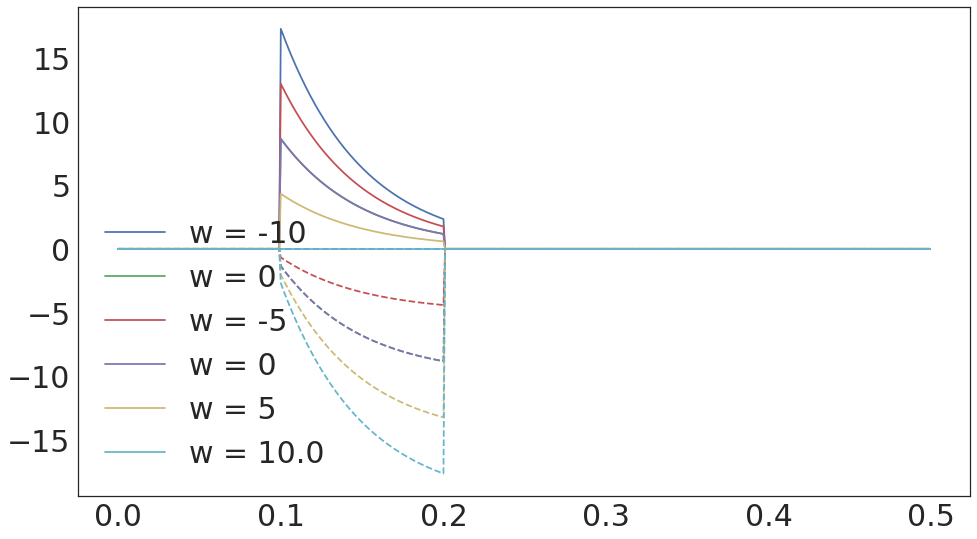

In [33]:
w_collection = [-10,0, -5, 0, 5, 10.0]

for w in w_collection:
    dw_hebbian = (w_max - w) * z_post * z 
    dw_gatting = (w_min - w) * (1 - z) * z_post
    ln, = plt.plot(t, dw_hebbian, label='w = ' + str(w))
    plt.plot(t, dw_gatting, '--', color=ln.get_color())
    


plt.legend();


## Transition Connectivity Anlaysis

In [125]:
tau_z = 0.050
T_start_pre = 0.0
T1_pre = 0.100 
T1_post = T1_pre
T2_post = T1_post + T1_pre
w_max = 10
w_min = -10

tau_z_post = 0.050

dt = 0.001
t = np.arange(0, 0.500, dt)
z = z_filter(t, tau_z, T1_pre, T_start_pre)
z_post = box_car(t, T1_post, T2_post)

#### pre-synaptic gatting

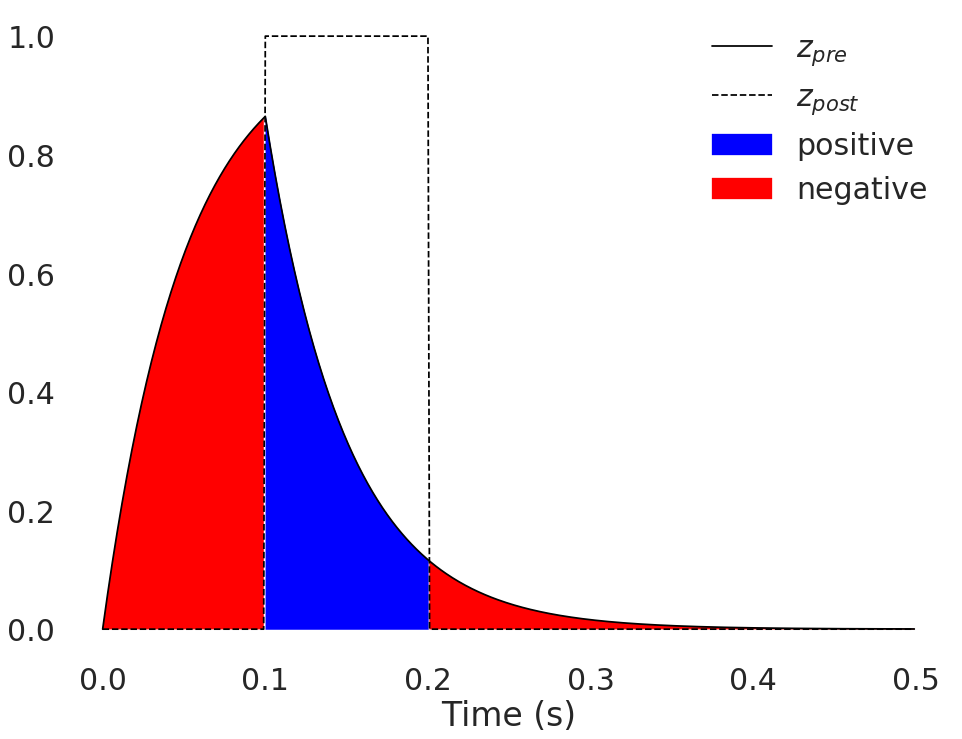

In [126]:
sns.set_style('white')

fig = plt.figure(figsize=(16, 12))
ax =  fig.add_subplot(111)

ax.plot(t, z, color='black', label=r'$z_{pre}$')
ax.plot(t, z_post, ls='--', color='black', label=r'$z_{post}$')
ax.set_xlabel('Time (s)')

x_fill = (t <= T2_post) * (t >= T1_post) 
ax.fill_between(t, 0, z, where=x_fill, color='blue', label='positive')
ax.fill_between(t, 0 , z, where=np.logical_not(x_fill), color='red', label='negative')

for spine in plt.gca().spines.values():
    spine.set_visible(False)
# ax.axis('off')

ax.legend();

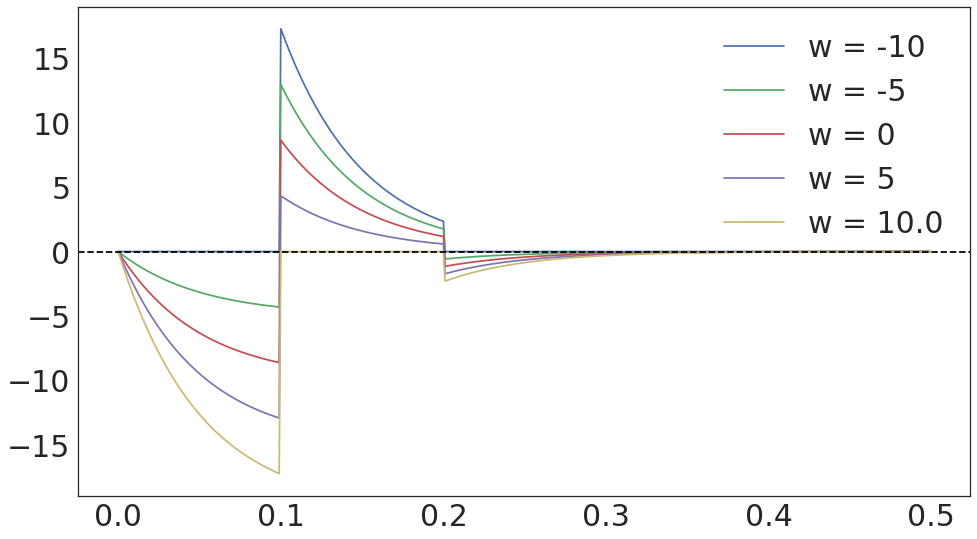

In [127]:
w_collection = [-10, -5, 0, 5, 10.0]

decomposed = False

for w in w_collection:
    dw_hebbian = (w_max - w) * z_post * z 
    dw_gatting = (w_min - w) * (1 - z_post) * z
    dw_total = dw_hebbian + dw_gatting
    if decomposed:
        ln, = plt.plot(t, dw_hebbian, ':', label='w = ' + str(w))
        plt.plot(t, dw_gatting, '--', color=ln.get_color())
        plt.plot(t, dw_total, '-', color=ln.get_color())
    else:
        plt.plot(t, dw_total, label='w = ' + str(w))

        
plt.axhline(0, ls='--', color='black')
plt.legend(loc=1);

#### Post-synaptic gatting

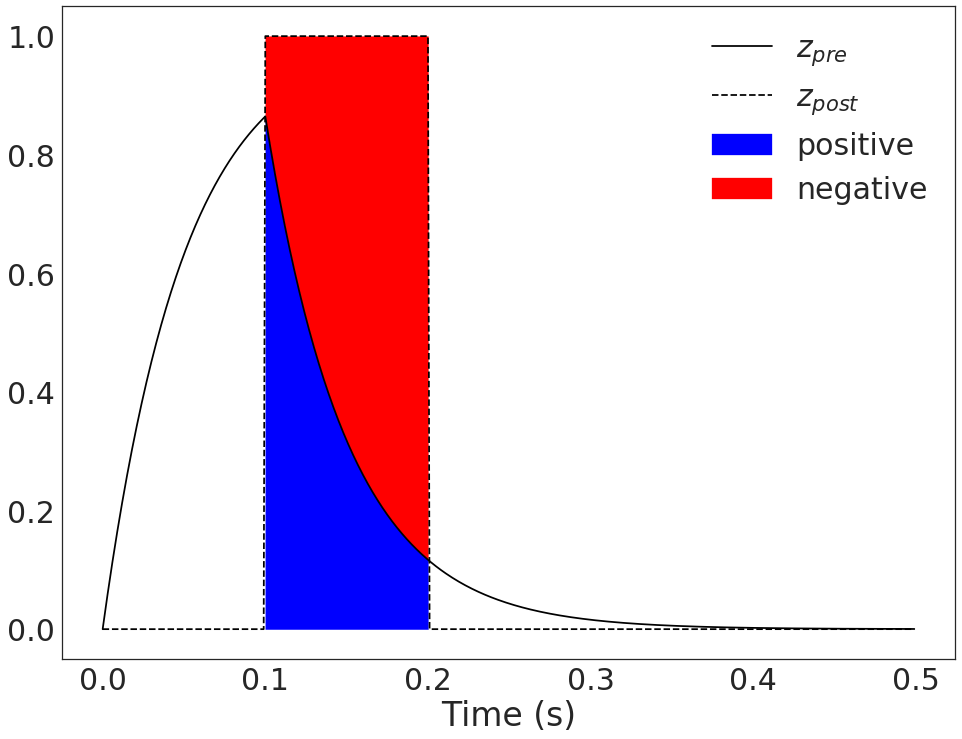

In [128]:
sns.set_style('white')

fig = plt.figure(figsize=(16, 12))
ax =  fig.add_subplot(111)

ax.plot(t, z, color='black', label=r'$z_{pre}$')
ax.plot(t, z_post, ls='--', color='black', label=r'$z_{post}$')
ax.set_xlabel('Time (s)')

x_fill = (t <= T2_post) * (t >= T1_post) 
ax.fill_between(t, 0, z, where=x_fill, color='blue', label='positive')
ax.fill_between(t, z, z_post, where=x_fill, color='red', label='negative')

ax.legend();

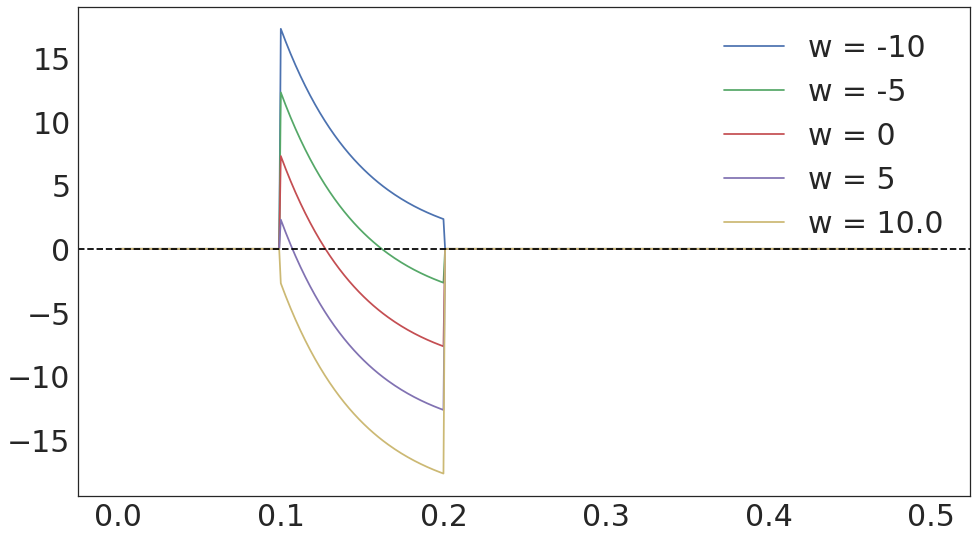

In [130]:
w_collection = [-10, -5, 0, 5, 10.0]

decomposed = False


for w in w_collection:
    dw_hebbian = (w_max - w) * z_post * z 
    dw_gatting = (w_min - w) * (1 - z) * z_post
    dw_total = dw_hebbian + dw_gatting
    if decomposed:
        ln, = plt.plot(t, dw_hebbian, ':', label='w = ' + str(w))
        plt.plot(t, dw_gatting, '--', color=ln.get_color())
        plt.plot(t, dw_total, '-', color=ln.get_color())
    else:
        plt.plot(t, dw_total, label='w = ' + str(w))

plt.axhline(0, ls='--', color='black')
plt.legend(loc=1);

## Self-connectivity analysis

In [138]:
tau_z = 0.050
T_start_pre = 0.0
T1_pre = 0.500 
T1_post = 0.0
T2_post = T1_pre
w_max = 10
w_min = -10

tau_z_post = 0.050

dt = 0.001
t = np.arange(0, 1.000, dt)
z = z_filter(t, tau_z, T1_pre, T_start_pre)
z_post = box_car(t, T1_post, T2_post)

#### pre-synaptic

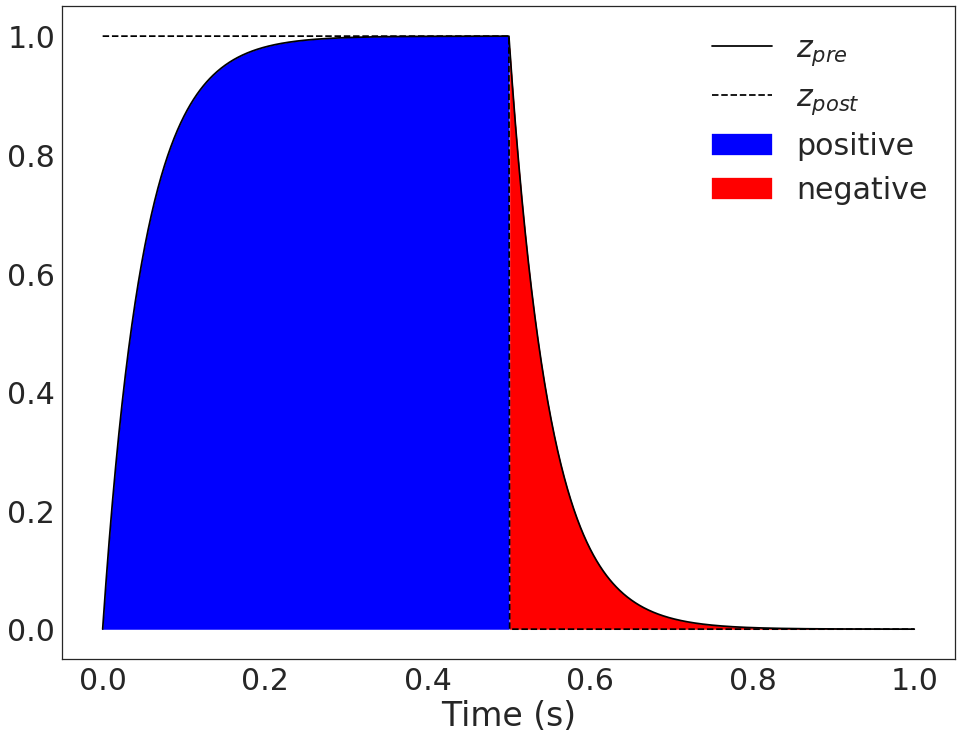

In [139]:
sns.set_style('white')

fig = plt.figure(figsize=(16, 12))
ax =  fig.add_subplot(111)

ax.plot(t, z, color='black', label=r'$z_{pre}$')
ax.plot(t, z_post, ls='--', color='black', label=r'$z_{post}$')
ax.set_xlabel('Time (s)')

x_fill = (t <= T2_post) * (t >= T1_post) 
ax.fill_between(t, 0, z, where=x_fill, color='blue', label='positive')
ax.fill_between(t, 0 , z, where=np.logical_not(x_fill), color='red', label='negative')

ax.legend();

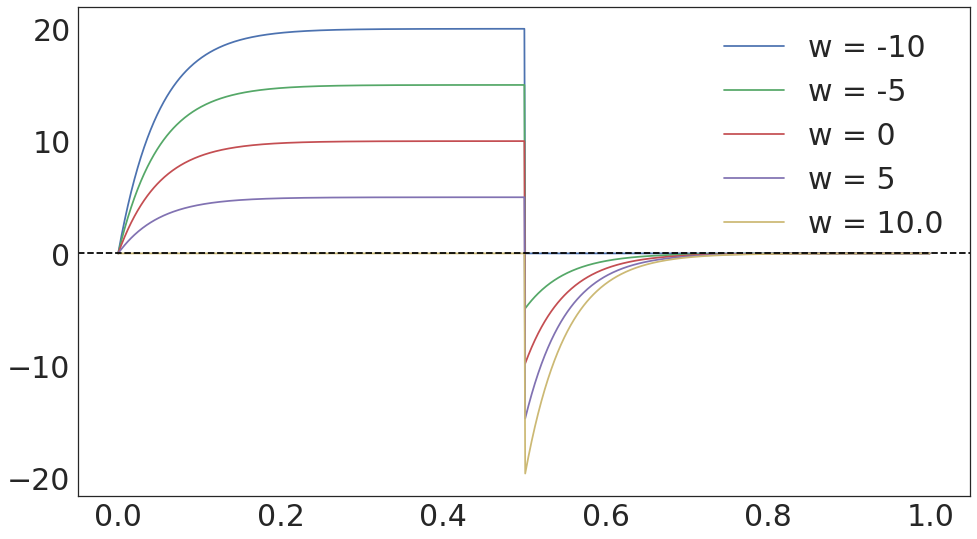

In [140]:
w_collection = [-10, -5, 0, 5, 10.0]

decomposed = False

for w in w_collection:
    dw_hebbian = (w_max - w) * z_post * z 
    dw_gatting = (w_min - w) * (1 - z_post) * z
    dw_total = dw_hebbian + dw_gatting
    if decomposed:
        ln, = plt.plot(t, dw_hebbian, ':', label='w = ' + str(w))
        plt.plot(t, dw_gatting, '--', color=ln.get_color())
        plt.plot(t, dw_total, '-', color=ln.get_color())
    else:
        plt.plot(t, dw_total, label='w = ' + str(w))

plt.axhline(0, ls='--', color='black')
plt.legend(loc=1);


#### Post-synaptic gatting

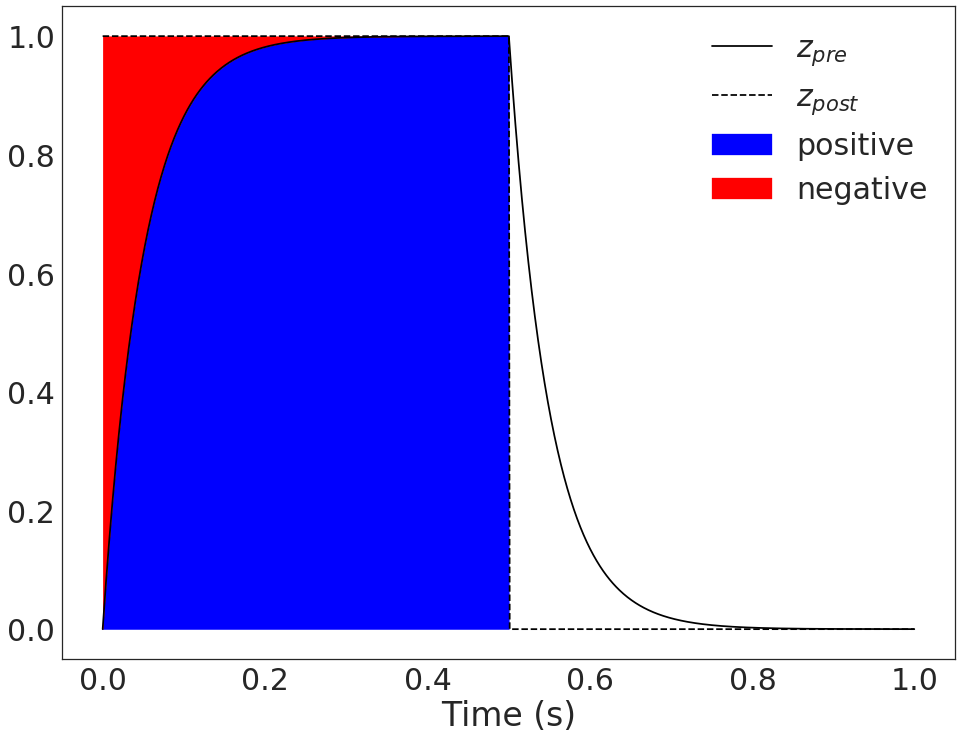

In [142]:
sns.set_style('white')

fig = plt.figure(figsize=(16, 12))
ax =  fig.add_subplot(111)

ax.plot(t, z, color='black', label=r'$z_{pre}$')
ax.plot(t, z_post, ls='--', color='black', label=r'$z_{post}$')
ax.set_xlabel('Time (s)')

x_fill = (t <= T2_post) * (t >= T1_post) 
ax.fill_between(t, 0, z, where=x_fill, color='blue', label='positive')
ax.fill_between(t, z, z_post, where=x_fill, color='red', label='negative')


ax.legend();

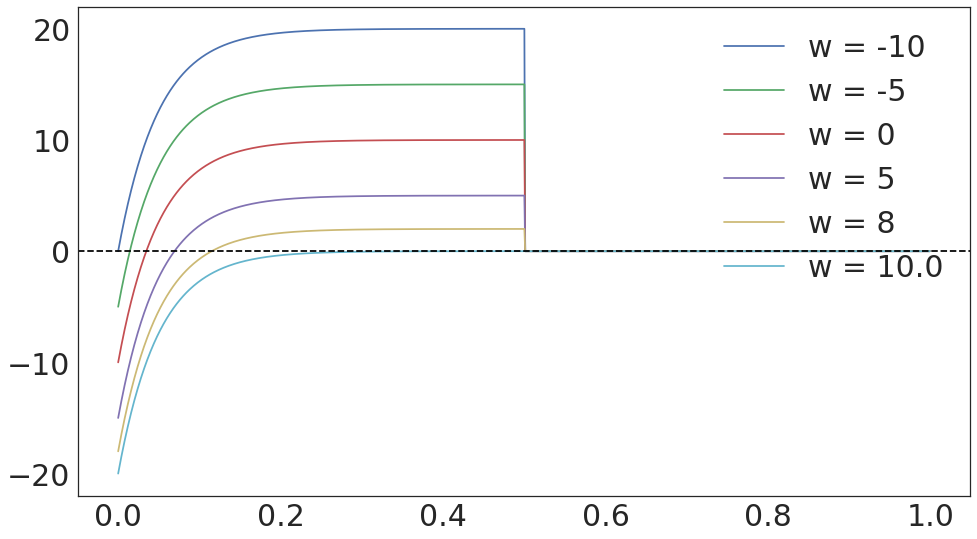

In [144]:
w_collection = [-10, -5, 0, 5, 8, 10.0]

decomposed = False


for w in w_collection:
    dw_hebbian = (w_max - w) * z_post * z 
    dw_gatting = (w_min - w) * (1 - z) * z_post
    dw_total = dw_hebbian + dw_gatting
    if decomposed:
        ln, = plt.plot(t, dw_hebbian, ':', label='w = ' + str(w))
        plt.plot(t, dw_gatting, '--', color=ln.get_color())
        plt.plot(t, dw_total, '-', color=ln.get_color())
    else:
        plt.plot(t, dw_total, label='w = ' + str(w))


plt.axhline(0, ls='--', color='black')
plt.legend(loc=1);


## Backward connectivity analysis

In [145]:
tau_z = 0.050
T_start_pre = 0.100
T1_pre = 0.200 

T1_post = 0
T2_post = T_start_pre
w_max = 10
w_min = -10

tau_z_post = 0.050

dt = 0.001
t = np.arange(0, 0.800, dt)
z = z_filter(t, tau_z, T1_pre, T_start_pre)
z_post = box_car(t, T1_post, T2_post)

#### Pre-synaptic gatting

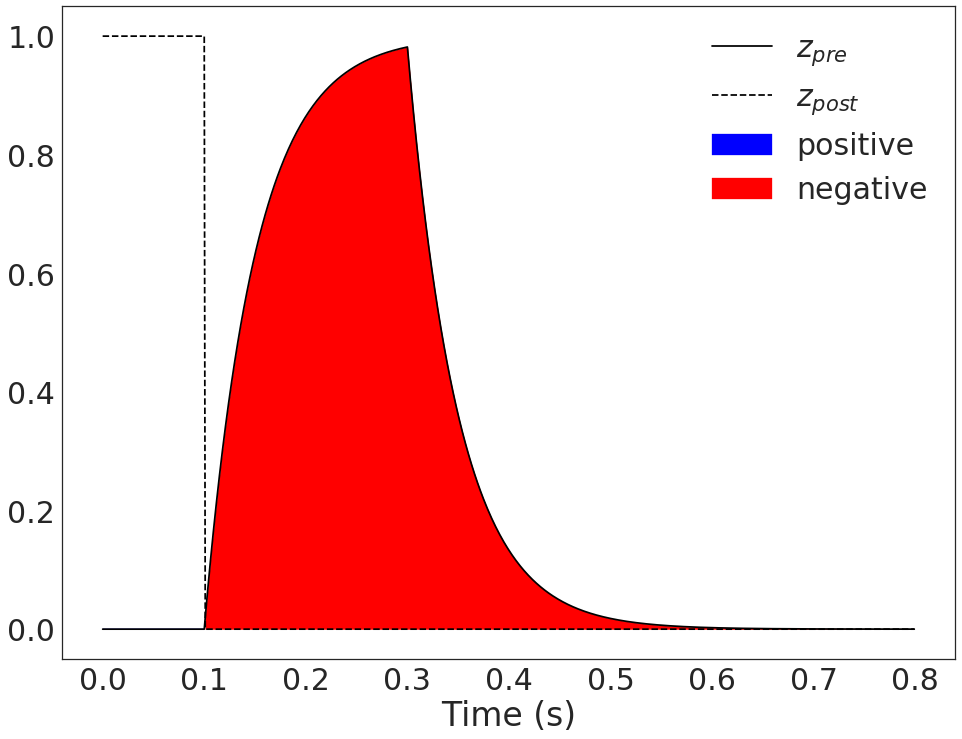

In [146]:
sns.set_style('white')

fig = plt.figure(figsize=(16, 12))
ax =  fig.add_subplot(111)

ax.plot(t, z, color='black', label=r'$z_{pre}$')
ax.plot(t, z_post, ls='--', color='black', label=r'$z_{post}$')
ax.set_xlabel('Time (s)')

x_fill = (t <= T2_post) * (t >= T1_post) 
ax.fill_between(t, 0, z, where=x_fill, color='blue', label='positive')
ax.fill_between(t, 0 , z, where=np.logical_not(x_fill), color='red', label='negative')

ax.legend();

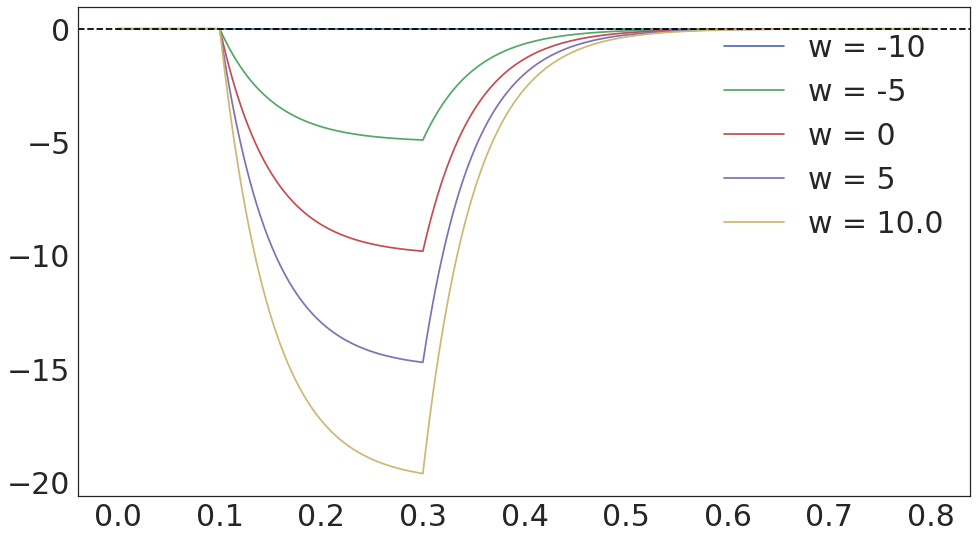

In [147]:
w_collection = [-10, -5, 0, 5, 10.0]

decomposed = False

for w in w_collection:
    dw_hebbian = (w_max - w) * z_post * z 
    dw_gatting = (w_min - w) * (1 - z_post) * z
    dw_total = dw_hebbian + dw_gatting
    if decomposed:
        ln, = plt.plot(t, dw_hebbian, ':', label='w = ' + str(w))
        plt.plot(t, dw_gatting, '--', color=ln.get_color())
        plt.plot(t, dw_total, '-', color=ln.get_color())
    else:
        plt.plot(t, dw_total, label='w = ' + str(w))

plt.axhline(0, ls='--', color='black')
plt.legend(loc=1);


##### Post-synaptic gatting

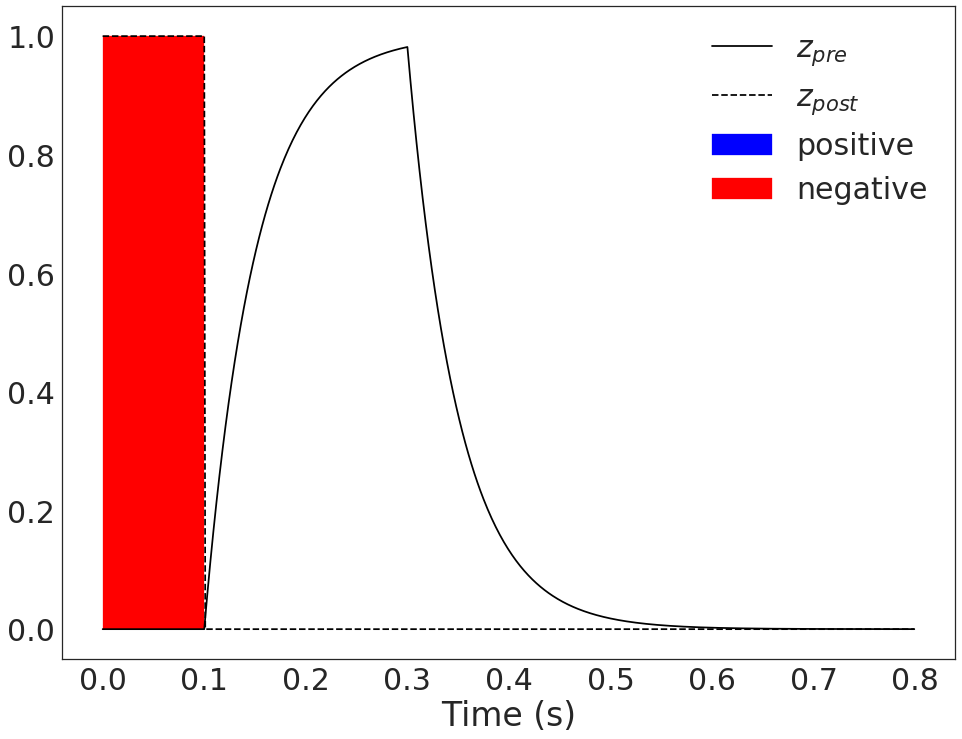

In [148]:
sns.set_style('white')

fig = plt.figure(figsize=(16, 12))
ax =  fig.add_subplot(111)

ax.plot(t, z, color='black', label=r'$z_{pre}$')
ax.plot(t, z_post, ls='--', color='black', label=r'$z_{post}$')
ax.set_xlabel('Time (s)')

x_fill = (t <= T2_post) * (t >= T1_post) 
ax.fill_between(t, 0, z, where=x_fill, color='blue', label='positive')
ax.fill_between(t, z, z_post, where=x_fill, color='red', label='negative')


ax.legend();

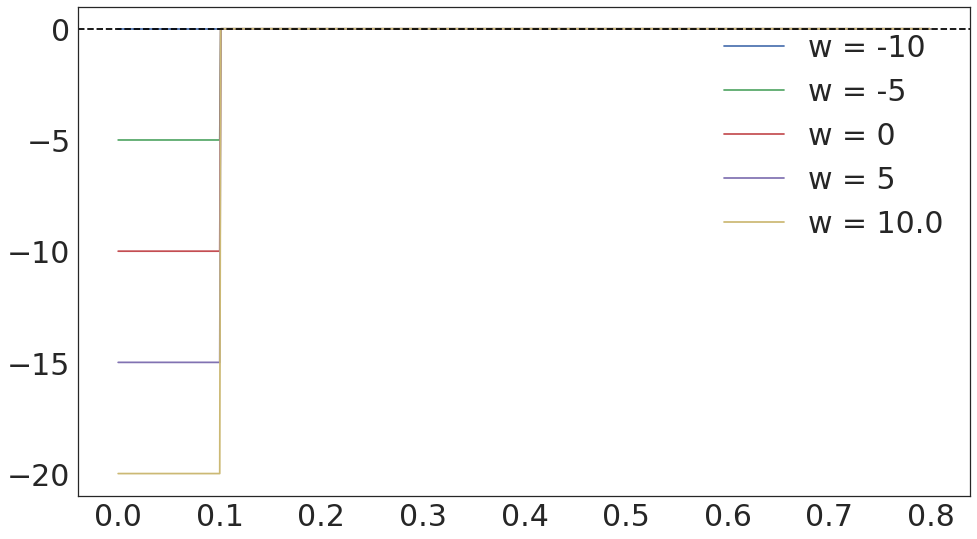

In [149]:
w_collection = [-10, -5, 0, 5, 10.0]

decomposed = False


for w in w_collection:
    dw_hebbian = (w_max - w) * z_post * z 
    dw_gatting = (w_min - w) * (1 - z) * z_post
    dw_total = dw_hebbian + dw_gatting
    if decomposed:
        ln, = plt.plot(t, dw_hebbian, ':', label='w = ' + str(w))
        plt.plot(t, dw_gatting, '--', color=ln.get_color())
        plt.plot(t, dw_total, '-', color=ln.get_color())
    else:
        plt.plot(t, dw_total, label='w = ' + str(w))


plt.axhline(0, ls='--', color='black')
plt.legend(loc=1);

## Far away connectivity anlaysis

In [119]:
tau_z = 0.050
T_start_pre = 0.0
T1_pre = 0.100 

T1_post = 0.400
T2_post = 0.500
w_max = 10
w_min = -10

tau_z_post = 0.050

dt = 0.001
t = np.arange(0, 0.800, dt)
z = z_filter(t, tau_z, T1_pre, T_start_pre)
z_post = box_car(t, T1_post, T2_post)

#### Pre-synaptic gatting

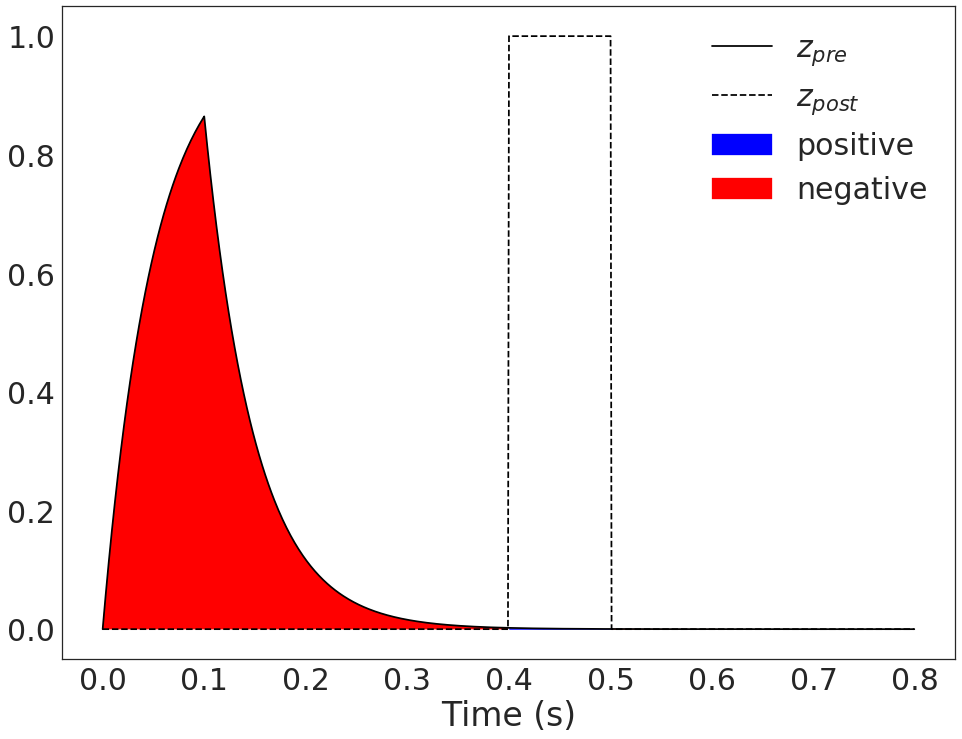

In [120]:
sns.set_style('white')

fig = plt.figure(figsize=(16, 12))
ax =  fig.add_subplot(111)

ax.plot(t, z, color='black', label=r'$z_{pre}$')
ax.plot(t, z_post, ls='--', color='black', label=r'$z_{post}$')
ax.set_xlabel('Time (s)')

x_fill = (t <= T2_post) * (t >= T1_post) 
ax.fill_between(t, 0, z, where=x_fill, color='blue', label='positive')
ax.fill_between(t, 0 , z, where=np.logical_not(x_fill), color='red', label='negative')

ax.legend();

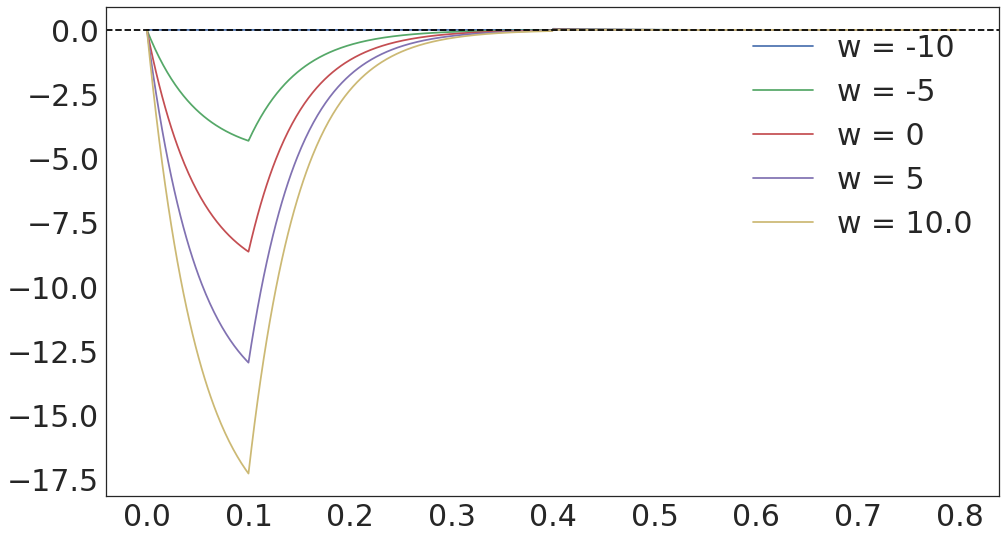

In [122]:
w_collection = [-10, -5, 0, 5, 10.0]

decomposed = False

for w in w_collection:
    dw_hebbian = (w_max - w) * z_post * z 
    dw_gatting = (w_min - w) * (1 - z_post) * z
    dw_total = dw_hebbian + dw_gatting
    if decomposed:
        ln, = plt.plot(t, dw_hebbian, ':', label='w = ' + str(w))
        plt.plot(t, dw_gatting, '--', color=ln.get_color())
        plt.plot(t, dw_total, '-', color=ln.get_color())
    else:
        plt.plot(t, dw_total, label='w = ' + str(w))

plt.axhline(0, ls='--', color='black')
plt.legend(loc=1);

#### Post-synaptic gatting

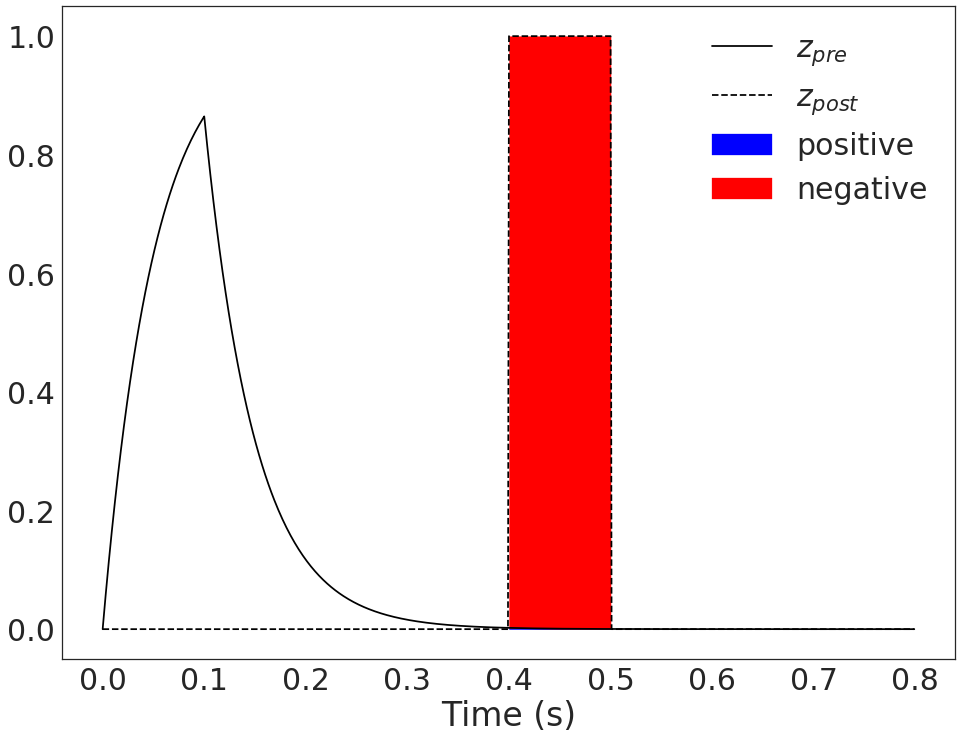

In [123]:
sns.set_style('white')

fig = plt.figure(figsize=(16, 12))
ax =  fig.add_subplot(111)

ax.plot(t, z, color='black', label=r'$z_{pre}$')
ax.plot(t, z_post, ls='--', color='black', label=r'$z_{post}$')
ax.set_xlabel('Time (s)')

x_fill = (t <= T2_post) * (t >= T1_post) 
ax.fill_between(t, 0, z, where=x_fill, color='blue', label='positive')
ax.fill_between(t, z, z_post, where=x_fill, color='red', label='negative')


ax.legend();

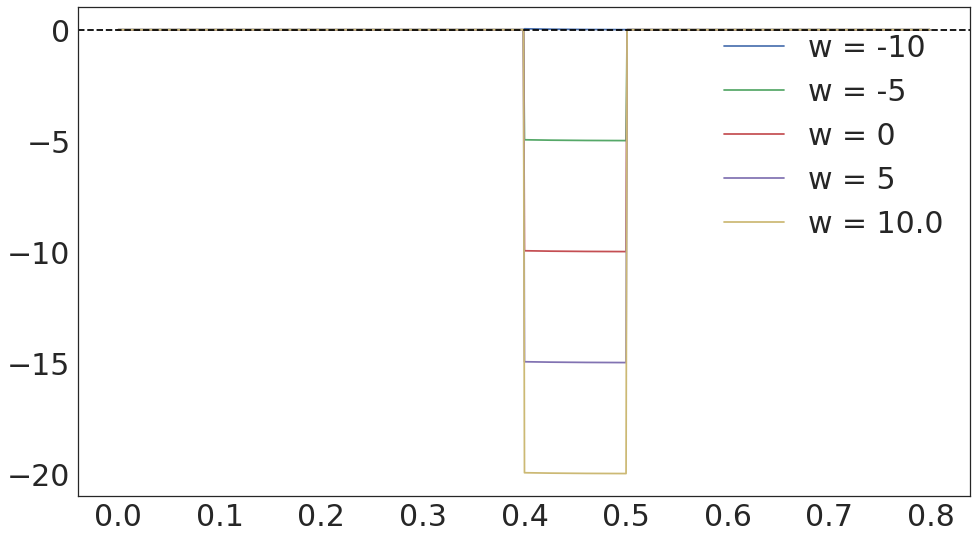

In [124]:
w_collection = [-10, -5, 0, 5, 10.0]

decomposed = False


for w in w_collection:
    dw_hebbian = (w_max - w) * z_post * z 
    dw_gatting = (w_min - w) * (1 - z) * z_post
    dw_total = dw_hebbian + dw_gatting
    if decomposed:
        ln, = plt.plot(t, dw_hebbian, ':', label='w = ' + str(w))
        plt.plot(t, dw_gatting, '--', color=ln.get_color())
        plt.plot(t, dw_total, '-', color=ln.get_color())
    else:
        plt.plot(t, dw_total, label='w = ' + str(w))


plt.axhline(0, ls='--', color='black')
plt.legend(loc=1);